# Introduction

This time I am entering the Titanic - Machine Learning from Disaster competition.

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import os

In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "titanic survival prediction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
train_full_ = pd.read_csv('train.csv')
test_ = pd.read_csv('test.csv')

Let's have a look at the train data

In [4]:
#Dropping the name variable
train_full_ = train_full_.drop(['Name'], axis=1, inplace=False)

In [5]:
train_full = train_full_.copy()
test= test_.copy()

In [6]:
train_full.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S


Since Kaggle didnt give a data description, I will explain the variables below

* **PassengerId**: a unique identifier for each passenger
* **Survived**: the target variable, 0 means the passenger did not survive, while 1 means the passenger survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: this should be self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

I dont think the ticket id and name variables would be needed, hence I might have to remove it later.

In [7]:
#Set index to passenger id
train_full = train_full.set_index("PassengerId")
test = test.set_index("PassengerId")

## Exploratory Data Analysis And Data Wrangling

In [8]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Ticket    891 non-null    object 
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB


There are missing data and I will have to fix that

Lets see how many missing values that are actually present in the data

In [9]:
train_full.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Some quick observations I have made from the infomation about the data is that the SibSp and Parch variables have to be added together and the age variable should be more of a category

### Changing Age variable to category

In [10]:
train_full["AgeBucket"] = train_full["Age"] // 15 * 15
train_full[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [11]:
test["AgeBucket"] = test["Age"] // 15 * 15

In [12]:
train_full.AgeBucket = train_full.AgeBucket.astype(str)

test.AgeBucket = test.AgeBucket.astype(str)

In [13]:
#Adding the SibSp and Parch variables

train_full["RelativesOnBoard"] = train_full["SibSp"] + train_full["Parch"]
train_full[["RelativesOnBoard", "Survived"]].groupby(
    ['RelativesOnBoard']).mean()

,Survived
RelativesOnBoard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [14]:
test["RelativesOnBoard"] = test["SibSp"] + test["Parch"]

Lets see what the dataset looks like now

In [15]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Survived          891 non-null    int64  
 1   Pclass            891 non-null    int64  
 2   Sex               891 non-null    object 
 3   Age               714 non-null    float64
 4   SibSp             891 non-null    int64  
 5   Parch             891 non-null    int64  
 6   Ticket            891 non-null    object 
 7   Fare              891 non-null    float64
 8   Cabin             204 non-null    object 
 9   Embarked          889 non-null    object 
 10  AgeBucket         891 non-null    object 
 11  RelativesOnBoard  891 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


In [16]:
train_full['Cabin'].value_counts()

G6             4
B96 B98        4
C23 C25 C27    4
F2             3
D              3
              ..
C47            1
B39            1
B50            1
B73            1
F E69          1
Name: Cabin, Length: 147, dtype: int64

In [17]:
train_full.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292
RelativesOnBoard,891.0,0.904602,1.613459,0.00,0.0000,0.0000,1.0,10.0000


array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>],
       [<AxesSubplot:title={'center':'RelativesOnBoard'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

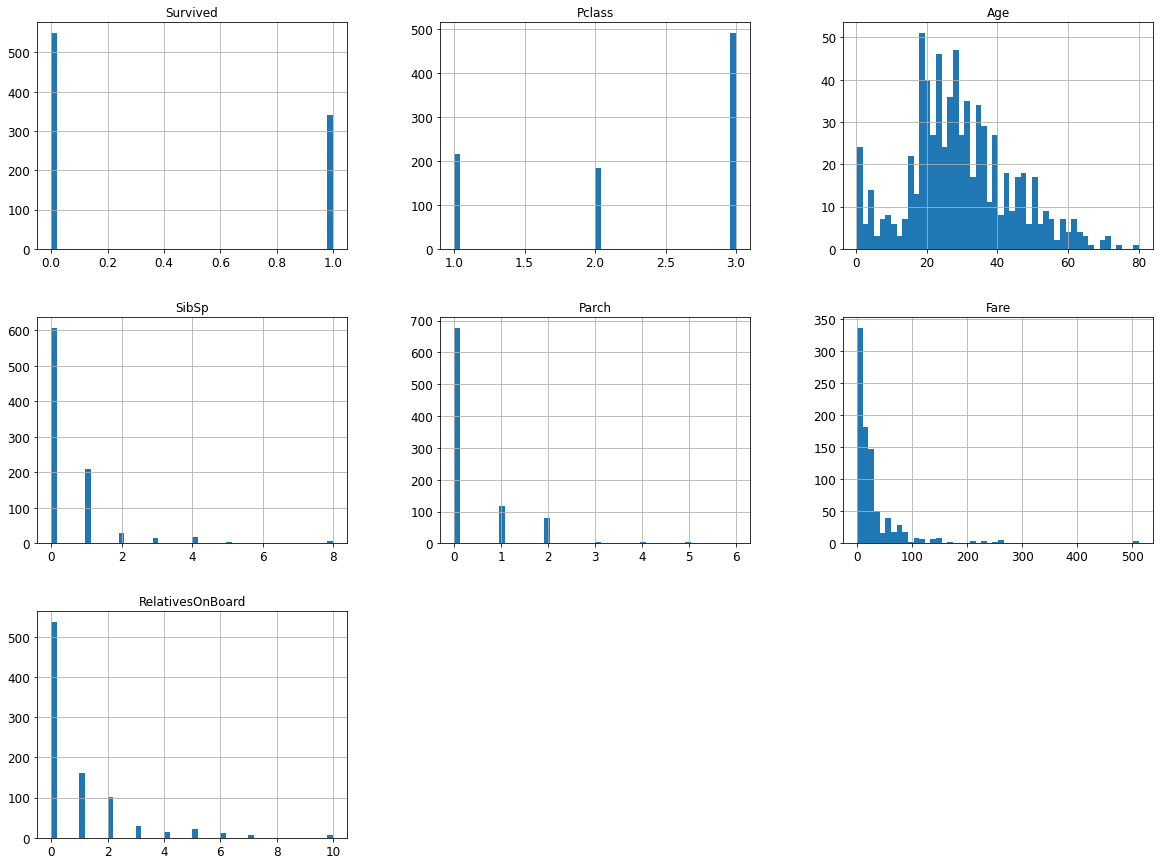

In [18]:
train_full.hist(bins=50, figsize=(20,15))

In [19]:
#Splitting the data
X = train_full.drop("Survived", axis=1)
y = train_full["Survived"].copy()

In [20]:
#Splitting the dataset into training and test data
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
#Lets check the correlation

corr_matrix = train_full.corr()

In [22]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived            1.000000
Fare                0.257307
Parch               0.081629
RelativesOnBoard    0.016639
SibSp              -0.035322
Age                -0.077221
Pclass             -0.338481
Name: Survived, dtype: float64

Let me build the preprocessing pipelines, starting with the pipeline for numerical attributes

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

In [24]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ])

In [25]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare", "RelativesOnBoard"]
cat_attribs = ["Pclass", "Sex", "Embarked", "AgeBucket", "Cabin"]

preprocessor = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [26]:
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in 1.0.0."""
    from inspect import Signature, signature, Parameter
    
    from sklearn.preprocessing import FunctionTransformer

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if self.feature_names_out is None:
                return default_get_feature_names_out(self, names)
            elif callable(self.feature_names_out):
                return self.feature_names_out(names)
            else:
                return self.feature_names_out

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()


Monkey-patching SimpleImputer.get_feature_names_out()
Monkey-patching FunctionTransformer.get_feature_names_out()


In [27]:
train = preprocessor.fit_transform(X_train)
train

array([[ 1.25364106, -0.47072241, -0.47934164, ...,  0.        ,
         0.        ,  0.        ],
       [-0.47728355, -0.47072241, -0.47934164, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.21508629, -0.47072241, -0.47934164, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.90745614,  1.23056874, -0.47934164, ...,  0.        ,
         0.        ,  0.        ],
       [-1.1696534 ,  0.37992316,  2.04874166, ...,  0.        ,
         0.        ,  0.        ],
       [-0.63114352, -0.47072241,  0.78470001, ...,  0.        ,
         0.        ,  0.        ]])

In [28]:
train = pd.DataFrame(
    train,
    columns=preprocessor.get_feature_names_out(),
    index=X_train.index)

train.head()

,num__Age,num__SibSp,num__Parch,num__Fare,num__RelativesOnBoard,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,...,cat__Cabin_E8,cat__Cabin_F E69,cat__Cabin_F G63,cat__Cabin_F G73,cat__Cabin_F2,cat__Cabin_F33,cat__Cabin_F38,cat__Cabin_F4,cat__Cabin_G6,cat__Cabin_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
332,1.253641,-0.470722,-0.479342,-0.078684,-0.554666,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
734,-0.477284,-0.470722,-0.479342,-0.377145,-0.554666,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
383,0.215086,-0.470722,-0.479342,-0.474867,-0.554666,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
705,-0.246494,0.379923,-0.479342,-0.476230,0.040096,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
814,-1.785093,2.931860,2.048742,-0.025249,3.013909,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(random_state=42)),
])

rf_classifier.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare',
                                                   'RelativesOnBoard']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                               

In [30]:
some_data = X_train.iloc[:5]
some_labels = y_train.iloc[:5]

print("Predictions:", list(rf_classifier.predict(some_data)))

Predictions: [0, 0, 0, 0, 0]


In [31]:
print("Labels:", list(some_labels))

Labels: [0, 0, 0, 0, 0]


In [32]:
#Now lets evaluate the rf model. ie training error
from sklearn.metrics import accuracy_score

rf_classifier_predictions = rf_classifier.predict(X_train)
rf_classifier_accuracy = accuracy_score(y_train, rf_classifier_predictions)
rf_classifier_accuracy

0.9845505617977528

And I have gotten 98% accuracy!. Thats very impressive cl

In [33]:
from sklearn.model_selection import cross_val_score

rf_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)
rf_scores.mean()

0.8019895597360385

The random forest is overfitting the training set

### Feature Selection

Lets see the feature importances and perform feature selection

In [34]:
feature_importances = rf_classifier["rf"].feature_importances_
feature_importances

array([1.51040181e-01, 3.44630879e-02, 2.76191829e-02, 1.87362682e-01,
       4.58823410e-02, 1.86213756e-02, 1.65738847e-02, 4.19584906e-02,
       1.12014495e-01, 1.45647325e-01, 1.49912306e-02, 7.03768313e-03,
       1.62329921e-02, 1.49129217e-02, 1.55788453e-02, 1.05238146e-02,
       7.53210124e-03, 4.48791962e-03, 1.02882193e-03, 1.01851754e-02,
       6.13956703e-04, 2.36660646e-04, 2.36509199e-04, 3.47077169e-04,
       1.46087359e-03, 2.43371738e-04, 1.38214432e-03, 4.18879564e-04,
       5.17173044e-04, 3.44478570e-04, 9.15509342e-04, 2.58542301e-04,
       1.50487836e-04, 1.75309665e-04, 2.05517336e-03, 3.05266786e-04,
       3.77502900e-04, 7.12874823e-05, 2.20908998e-04, 6.84692599e-04,
       6.19013480e-04, 6.35914785e-05, 7.99079627e-04, 3.99231121e-04,
       9.82366608e-04, 1.15134054e-04, 1.47717704e-03, 1.05010614e-03,
       1.98503347e-04, 7.62204668e-04, 5.06009764e-04, 5.78294066e-05,
       5.31543030e-04, 1.47828205e-04, 2.84982889e-04, 6.16782425e-04,
      

In [35]:
sorted(zip(feature_importances,
           rf_classifier["preprocessor"].get_feature_names_out()),reverse=True)

[(0.1873626815425593, 'num__Fare'),
 (0.1510401808640352, 'num__Age'),
 (0.14564732482011924, 'cat__Sex_male'),
 (0.1120144945569586, 'cat__Sex_female'),
 (0.04588234099310969, 'num__RelativesOnBoard'),
 (0.041958490608497045, 'cat__Pclass_3'),
 (0.03446308788461821, 'num__SibSp'),
 (0.03181692946420129, 'cat__Cabin_C23 C25 C27'),
 (0.027619182881597627, 'num__Parch'),
 (0.018621375585298396, 'cat__Pclass_1'),
 (0.01657388469735206, 'cat__Pclass_2'),
 (0.01623299211889465, 'cat__Embarked_S'),
 (0.015578845325229138, 'cat__AgeBucket_15.0'),
 (0.01499123063604554, 'cat__Embarked_C'),
 (0.01491292168842619, 'cat__AgeBucket_0.0'),
 (0.010523814577655225, 'cat__AgeBucket_30.0'),
 (0.010185175363486487, 'cat__AgeBucket_nan'),
 (0.007532101242079584, 'cat__AgeBucket_45.0'),
 (0.00703768313353037, 'cat__Embarked_Q'),
 (0.004487919617406285, 'cat__AgeBucket_60.0'),
 (0.004097463132075413, 'cat__Cabin_C22 C26'),
 (0.003963544721344499, 'cat__Cabin_C52'),
 (0.003288568971276743, 'cat__Cabin_E24')

From the feature importances, the new variable that I created RelativesOnBoard is far more important that the number siblings & spouses and children & parents.

Now lets see the optimal number of features to select

In [36]:
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, expon

selector = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('rf', RandomForestClassifier()),
    
])


param_distribs = {'selector__threshold': np.arange(0.001, 0.1, 0.001)}

In [37]:
selector_rnd_search = RandomizedSearchCV(selector, param_distributions=param_distribs,
                                n_iter=100, cv=5, scoring="accuracy", random_state=42,
                                            return_train_score=True)

In [38]:
selector_rnd_search.fit(X_train, y_train)

C:\Users\nwokedi.m.j\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 99 is smaller than n_iter=100. Running 99 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'SibSp',
                                                                                'Parch',
                                                                                'Fare',
             

In [39]:
selector_rnd_search.best_params_

{'selector__threshold': 0.036000000000000004}

In [40]:
cv_res_selector_rnd = pd.DataFrame(selector_rnd_search.cv_results_)
cv_res_selector_rnd.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res_selector_rnd

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selector__threshold,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
42,0.328102,0.013974,0.037498,0.007655,0.043,{'selector__threshold': 0.043000000000000003},0.811189,0.825175,0.781690,0.838028,...,0.816005,0.019146,1,0.978910,0.984183,0.980702,0.978947,0.982456,0.981040,0.002045
35,0.365600,0.037757,0.034373,0.006249,0.036,{'selector__threshold': 0.036000000000000004},0.818182,0.818182,0.795775,0.809859,...,0.816005,0.013723,1,0.980668,0.984183,0.980702,0.980702,0.982456,0.981742,0.001399
31,0.380792,0.037815,0.041442,0.008456,0.032,{'selector__threshold': 0.032},0.825175,0.811189,0.781690,0.809859,...,0.814597,0.020772,3,0.982425,0.984183,0.980702,0.980702,0.982456,0.982094,0.001302
29,0.415872,0.039494,0.043367,0.011615,0.03,{'selector__threshold': 0.030000000000000002},0.839161,0.804196,0.788732,0.802817,...,0.814587,0.020339,4,0.982425,0.984183,0.980702,0.980702,0.982456,0.982094,0.001302
40,0.368720,0.040263,0.034376,0.006247,0.041,{'selector__threshold': 0.041},0.832168,0.825175,0.767606,0.823944,...,0.814567,0.023679,5,0.980668,0.984183,0.980702,0.978947,0.982456,0.981391,0.001783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.334351,0.012494,0.034366,0.006254,0.06,{'selector__threshold': 0.060000000000000005},0.734266,0.727273,0.746479,0.788732,...,0.758505,0.028321,95,0.978910,0.984183,0.978947,0.978947,0.980702,0.980338,0.002041
54,0.346853,0.011686,0.034370,0.006252,0.055,{'selector__threshold': 0.055},0.748252,0.720280,0.739437,0.788732,...,0.758495,0.029095,96,0.978910,0.984183,0.978947,0.978947,0.980702,0.980338,0.002041
94,0.406222,0.009881,0.040623,0.007653,0.095,{'selector__threshold': 0.095},0.748252,0.727273,0.746479,0.795775,...,0.758485,0.023978,97,0.978910,0.984183,0.978947,0.978947,0.980702,0.980338,0.002041
55,0.340611,0.011686,0.031238,0.000009,0.056,{'selector__threshold': 0.056},0.741259,0.734266,0.739437,0.802817,...,0.758485,0.026354,97,0.978910,0.984183,0.978947,0.978947,0.980702,0.980338,0.002041


From the Randomized search above, the optimal threshold lies between 0.027 and 0.043.

I will now use Grid search to confirm the optimal selector threshold

In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'selector__threshold': [0.030, 0.031, 0.032, 0.035,0.037,  0.038, 0.040]}
]

grid_search = GridSearchCV(selector, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare',
                                                                          'Rela

In [42]:
grid_search.best_params_

{'selector__threshold': 0.04}

In [43]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8132079188417215 {'selector__threshold': 0.03}
0.8104205653501427 {'selector__threshold': 0.031}
0.8061755146262188 {'selector__threshold': 0.032}
0.8089628681177977 {'selector__threshold': 0.035}
0.8103713188220232 {'selector__threshold': 0.037}
0.8117797695262483 {'selector__threshold': 0.038}
0.814606520240323 {'selector__threshold': 0.04}


The optimal number of features is 0.04. I will now update the selector

In [44]:
selector = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(RandomForestClassifier(random_state=42), 
                                threshold=0.04)),
    ('rf', RandomForestClassifier(random_state=42)),
    
])

selector.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare',
                                                   'RelativesOnBoard']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                               

In [45]:
selector_predictions = selector.predict(X_train)
selector_accuracy = accuracy_score(y_train, selector_predictions)
selector_accuracy

0.9789325842696629

In [46]:
selector_scores = cross_val_score(selector, X_train, y_train, cv=5)
selector_scores.mean()

0.8047670639219934

The little reduction in training accuracy helps our model stop overfitting a little bit.

In [47]:
full_preprocessor = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(RandomForestClassifier(random_state=42), 
                                threshold=0.04)),
])

full_preprocessor.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare',
                                                   'RelativesOnBoard']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('cat_encoder',
                               

### Model Selection

In [48]:
#Lets try a svm classifier
from sklearn.svm import SVC 

svc = Pipeline([
    ('full_preprocessor', full_preprocessor),
    ('svc', SVC(gamma='auto')),
])

svc.fit(X_train, y_train)

Pipeline(steps=[('full_preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'SibSp',
                                                                    'Parch',
                                                                    'Fare',
                                                                    'RelativesOnBoard']),
                              

In [49]:
svc_predictions = svc.predict(X_train)
svc_accuracy = accuracy_score(y_train, svc_predictions)
svc_accuracy

0.8342696629213483

In [50]:
svc_scores = cross_val_score(svc, X_train, y_train, cv=5)
svc_scores.mean()

0.8173446272037822

The SVC generalises better than the random forest classifier!

In [77]:
from sklearn.linear_model import LogisticRegression

logistic_classifier = Pipeline([
    ('full_preprocessor', full_preprocessor),
    ('logistic_classifier', LogisticRegression()),
])

logistic_classifier.fit(X_train, y_train)

Pipeline(steps=[('full_preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'SibSp',
                                                                    'Parch',
                                                                    'Fare',
                                                                    'RelativesOnBoard']),
                              

In [78]:
logistic_classifier_predictions = logistic_classifier.predict(X_train)
logistic_classifier_accuracy = accuracy_score(y_train, logistic_classifier_predictions)
logistic_classifier_accuracy

0.8033707865168539

In [79]:
logistic_classifier_scores = cross_val_score(logistic_classifier, X_train, y_train, cv=5)
logistic_classifier_scores.mean()

0.7976952624839948

The logistic classifier also generalises better than the random forest classifier

### Hyperparameter Tuning

I will now perform hyperparameter tuning on the svc and logistic classifier

In [63]:
#Hyperparameter tuning on the svc
param_distribs = {'svc__C': np.arange(0.01, 1, 0.01),
                 'svc__gamma': ['scale', 'auto']}

svc_rnd_search = RandomizedSearchCV(svc, param_distributions=param_distribs,
                                n_iter=300, cv=5, scoring='accuracy',
                                verbose=2, random_state=42, return_train_score=True)
svc_rnd_search.fit(X_train, y_train)

C:\Users\nwokedi.m.j\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 198 is smaller than n_iter=300. Running 198 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 198 candidates, totalling 990 fits
[CV] END ......................svc__C=0.01, svc__gamma=scale; total time=   0.2s
[CV] END ......................svc__C=0.01, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.01, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.01, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.01, svc__gamma=scale; total time=   0.1s
[CV] END .......................svc__C=0.01, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.01, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.01, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.01, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.01, svc__gamma=auto; total time=   0.1s
[CV] END ......................svc__C=0.02, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.02, sv

[CV] END ......................svc__C=0.11, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.11, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.11, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.11, svc__gamma=scale; total time=   0.1s
[CV] END .......................svc__C=0.11, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.11, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.11, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.11, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.11, svc__gamma=auto; total time=   0.1s
[CV] END ......................svc__C=0.12, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.12, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.12, svc__gamma=scale; total time=   0.1s
[CV] END ...................

[CV] END .......svc__C=0.21000000000000002, svc__gamma=scale; total time=   0.1s
[CV] END .......svc__C=0.21000000000000002, svc__gamma=scale; total time=   0.1s
[CV] END ........svc__C=0.21000000000000002, svc__gamma=auto; total time=   0.1s
[CV] END ........svc__C=0.21000000000000002, svc__gamma=auto; total time=   0.1s
[CV] END ........svc__C=0.21000000000000002, svc__gamma=auto; total time=   0.1s
[CV] END ........svc__C=0.21000000000000002, svc__gamma=auto; total time=   0.1s
[CV] END ........svc__C=0.21000000000000002, svc__gamma=auto; total time=   0.1s
[CV] END ......................svc__C=0.22, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.22, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.22, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.22, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.22, svc__gamma=scale; total time=   0.1s
[CV] END ...................

[CV] END .......................svc__C=0.31, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.31, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.31, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.31, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.31, svc__gamma=auto; total time=   0.1s
[CV] END ......................svc__C=0.32, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.32, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.32, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.32, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.32, svc__gamma=scale; total time=   0.1s
[CV] END .......................svc__C=0.32, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.32, svc__gamma=auto; total time=   0.1s
[CV] END ...................

[CV] END ........svc__C=0.41000000000000003, svc__gamma=auto; total time=   0.1s
[CV] END ........svc__C=0.41000000000000003, svc__gamma=auto; total time=   0.1s
[CV] END ........svc__C=0.41000000000000003, svc__gamma=auto; total time=   0.1s
[CV] END .......svc__C=0.42000000000000004, svc__gamma=scale; total time=   0.1s
[CV] END .......svc__C=0.42000000000000004, svc__gamma=scale; total time=   0.1s
[CV] END .......svc__C=0.42000000000000004, svc__gamma=scale; total time=   0.1s
[CV] END .......svc__C=0.42000000000000004, svc__gamma=scale; total time=   0.1s
[CV] END .......svc__C=0.42000000000000004, svc__gamma=scale; total time=   0.1s
[CV] END ........svc__C=0.42000000000000004, svc__gamma=auto; total time=   0.1s
[CV] END ........svc__C=0.42000000000000004, svc__gamma=auto; total time=   0.1s
[CV] END ........svc__C=0.42000000000000004, svc__gamma=auto; total time=   0.1s
[CV] END ........svc__C=0.42000000000000004, svc__gamma=auto; total time=   0.1s
[CV] END ........svc__C=0.42

[CV] END .......................svc__C=0.51, svc__gamma=auto; total time=   0.1s
[CV] END ......................svc__C=0.52, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.52, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.52, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.52, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.52, svc__gamma=scale; total time=   0.1s
[CV] END .......................svc__C=0.52, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.52, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.52, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.52, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.52, svc__gamma=auto; total time=   0.1s
[CV] END ......................svc__C=0.53, svc__gamma=scale; total time=   0.1s
[CV] END ...................

[CV] END ......................svc__C=0.62, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.62, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.62, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.62, svc__gamma=scale; total time=   0.1s
[CV] END .......................svc__C=0.62, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.62, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.62, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.62, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.62, svc__gamma=auto; total time=   0.2s
[CV] END ......................svc__C=0.63, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.63, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.63, svc__gamma=scale; total time=   0.2s
[CV] END ...................

[CV] END ......................svc__C=0.72, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.72, svc__gamma=scale; total time=   0.1s
[CV] END .......................svc__C=0.72, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.72, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.72, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.72, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.72, svc__gamma=auto; total time=   0.1s
[CV] END ......................svc__C=0.73, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.73, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.73, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.73, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.73, svc__gamma=scale; total time=   0.1s
[CV] END ...................

[CV] END .........svc__C=0.8200000000000001, svc__gamma=auto; total time=   0.1s
[CV] END .........svc__C=0.8200000000000001, svc__gamma=auto; total time=   0.1s
[CV] END .........svc__C=0.8200000000000001, svc__gamma=auto; total time=   0.1s
[CV] END .........svc__C=0.8200000000000001, svc__gamma=auto; total time=   0.1s
[CV] END .........svc__C=0.8200000000000001, svc__gamma=auto; total time=   0.1s
[CV] END ........svc__C=0.8300000000000001, svc__gamma=scale; total time=   0.1s
[CV] END ........svc__C=0.8300000000000001, svc__gamma=scale; total time=   0.1s
[CV] END ........svc__C=0.8300000000000001, svc__gamma=scale; total time=   0.1s
[CV] END ........svc__C=0.8300000000000001, svc__gamma=scale; total time=   0.1s
[CV] END ........svc__C=0.8300000000000001, svc__gamma=scale; total time=   0.1s
[CV] END .........svc__C=0.8300000000000001, svc__gamma=auto; total time=   0.1s
[CV] END .........svc__C=0.8300000000000001, svc__gamma=auto; total time=   0.1s
[CV] END .........svc__C=0.8

[CV] END .......................svc__C=0.92, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.92, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.92, svc__gamma=auto; total time=   0.1s
[CV] END ......................svc__C=0.93, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.93, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.93, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.93, svc__gamma=scale; total time=   0.1s
[CV] END ......................svc__C=0.93, svc__gamma=scale; total time=   0.1s
[CV] END .......................svc__C=0.93, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.93, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.93, svc__gamma=auto; total time=   0.1s
[CV] END .......................svc__C=0.93, svc__gamma=auto; total time=   0.1s
[CV] END ...................

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('full_preprocessor',
                                              Pipeline(steps=[('preprocessor',
                                                               ColumnTransformer(transformers=[('num',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('scaler',
                                                                                                                 StandardScaler())]),
                                                                                                ['Age',
                                                                                             

In [64]:
cv_res_svc_rnd = pd.DataFrame(svc_rnd_search.cv_results_)
cv_res_svc_rnd.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res_svc_rnd.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__gamma,param_svc__C,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
196,0.234782,0.007373,0.027172,0.004608,scale,0.99,"{'svc__gamma': 'scale', 'svc__C': 0.99}",0.846154,0.839161,0.816901,...,0.824387,0.020312,1,0.834798,0.831283,0.840351,0.829825,0.833333,0.833918,0.003639
178,0.184670,0.006420,0.035320,0.005209,scale,0.9,"{'svc__gamma': 'scale', 'svc__C': 0.9}",0.846154,0.839161,0.816901,...,0.822978,0.022824,2,0.834798,0.831283,0.840351,0.829825,0.833333,0.833918,0.003639
188,0.199329,0.016984,0.038800,0.005033,scale,0.95,"{'svc__gamma': 'scale', 'svc__C': 0.9500000000...",0.846154,0.839161,0.816901,...,0.822978,0.022824,2,0.834798,0.831283,0.840351,0.829825,0.833333,0.833918,0.003639
172,0.173010,0.001403,0.041330,0.001571,scale,0.87,"{'svc__gamma': 'scale', 'svc__C': 0.87}",0.846154,0.839161,0.816901,...,0.822978,0.022824,2,0.833040,0.831283,0.840351,0.829825,0.833333,0.833566,0.003621
174,0.174783,0.001270,0.038401,0.003093,scale,0.88,"{'svc__gamma': 'scale', 'svc__C': 0.88}",0.846154,0.839161,0.816901,...,0.822978,0.022824,2,0.833040,0.831283,0.840351,0.829825,0.833333,0.833566,0.003621


Setting C and gamma to 0.99 and scale rspectively, increases the validation accuracy and makes it closer to the training accuracy.

So I will go ahead and update the hyperparameters in the svc pipeline

In [65]:
svc = Pipeline([
    ('full_preprocessor', full_preprocessor),
    ('svc', SVC(C=0.99, gamma='scale')),
])

svc.fit(X_train, y_train)

Pipeline(steps=[('full_preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'SibSp',
                                                                    'Parch',
                                                                    'Fare',
                                                                    'RelativesOnBoard']),
                              

In [66]:
svc_predictions = svc.predict(X_train)
svc_accuracy = accuracy_score(y_train, svc_predictions)
svc_accuracy

0.8356741573033708

In [67]:
svc_scores = cross_val_score(svc, X_train, y_train, cv=5)
svc_scores.mean()

0.824386880724909

In [82]:
#Hyperparameter tuning on the logistic classifier

param_distribs = {'logistic_classifier__C': np.arange(0.01, 1, 0.01),
                 }

logistic_classifier_rnd_search = RandomizedSearchCV(logistic_classifier, param_distributions=param_distribs,
                                n_iter=300, cv=5, scoring='accuracy',
                                verbose=2, random_state=42, return_train_score=True)

logistic_classifier_rnd_search.fit(X_train, y_train)

C:\Users\nwokedi.m.j\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 99 is smaller than n_iter=300. Running 99 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV] END ........................logistic_classifier__C=0.01; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.01; total time=   0.2s
[CV] END ........................logistic_classifier__C=0.01; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.01; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.01; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.02; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.02; total time=   0.2s
[CV] END ........................logistic_classifier__C=0.02; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.02; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.02; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.03; total time=   0.1s
[CV] END ........................logistic_class

[CV] END .........logistic_classifier__C=0.21000000000000002; total time=   0.1s
[CV] END .........logistic_classifier__C=0.21000000000000002; total time=   0.1s
[CV] END .........logistic_classifier__C=0.21000000000000002; total time=   0.1s
[CV] END .........logistic_classifier__C=0.21000000000000002; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.22; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.22; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.22; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.22; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.22; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.23; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.23; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.23; total time=   0.1s
[CV] END ...................

[CV] END .........logistic_classifier__C=0.41000000000000003; total time=   0.1s
[CV] END .........logistic_classifier__C=0.41000000000000003; total time=   0.1s
[CV] END .........logistic_classifier__C=0.42000000000000004; total time=   0.1s
[CV] END .........logistic_classifier__C=0.42000000000000004; total time=   0.1s
[CV] END .........logistic_classifier__C=0.42000000000000004; total time=   0.1s
[CV] END .........logistic_classifier__C=0.42000000000000004; total time=   0.2s
[CV] END .........logistic_classifier__C=0.42000000000000004; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.43; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.43; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.43; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.43; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.43; total time=   0.1s
[CV] END ...................

[CV] END ........................logistic_classifier__C=0.62; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.62; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.62; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.62; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.62; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.63; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.63; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.63; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.63; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.63; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.64; total time=   0.1s
[CV] END ........................logistic_classifier__C=0.64; total time=   0.1s
[CV] END ...................

[CV] END ..........logistic_classifier__C=0.8200000000000001; total time=   0.1s
[CV] END ..........logistic_classifier__C=0.8200000000000001; total time=   0.2s
[CV] END ..........logistic_classifier__C=0.8200000000000001; total time=   0.1s
[CV] END ..........logistic_classifier__C=0.8300000000000001; total time=   0.1s
[CV] END ..........logistic_classifier__C=0.8300000000000001; total time=   0.1s
[CV] END ..........logistic_classifier__C=0.8300000000000001; total time=   0.1s
[CV] END ..........logistic_classifier__C=0.8300000000000001; total time=   0.1s
[CV] END ..........logistic_classifier__C=0.8300000000000001; total time=   0.1s
[CV] END ..........logistic_classifier__C=0.8400000000000001; total time=   0.1s
[CV] END ..........logistic_classifier__C=0.8400000000000001; total time=   0.1s
[CV] END ..........logistic_classifier__C=0.8400000000000001; total time=   0.2s
[CV] END ..........logistic_classifier__C=0.8400000000000001; total time=   0.1s
[CV] END ..........logistic_

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('full_preprocessor',
                                              Pipeline(steps=[('preprocessor',
                                                               ColumnTransformer(transformers=[('num',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('scaler',
                                                                                                                 StandardScaler())]),
                                                                                                ['Age',
                                                                                             

In [83]:
cv_res_logistic_classifier_rnd = pd.DataFrame(logistic_classifier_rnd_search.cv_results_)
cv_res_logistic_classifier_rnd.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res_logistic_classifier_rnd.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic_classifier__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
8,0.200790,0.018920,0.031782,0.005242,0.09,{'logistic_classifier__C': 0.09},0.811189,0.825175,0.774648,0.746479,...,0.800512,0.035486,1,0.801406,0.787346,0.791228,0.794737,0.794737,0.793891,0.004644
16,0.205625,0.027296,0.021833,0.010695,0.17,{'logistic_classifier__C': 0.17},0.811189,0.825175,0.774648,0.753521,...,0.799104,0.030060,2,0.803163,0.787346,0.792982,0.792982,0.792982,0.793891,0.005124
4,0.218181,0.028271,0.026760,0.004030,0.05,{'logistic_classifier__C': 0.05},0.811189,0.825175,0.767606,0.746479,...,0.799104,0.036607,2,0.804921,0.787346,0.792982,0.796491,0.794737,0.795296,0.005708
5,0.195546,0.015010,0.024091,0.007663,0.06,{'logistic_classifier__C': 0.060000000000000005},0.811189,0.825175,0.767606,0.746479,...,0.799104,0.036607,2,0.801406,0.789104,0.792982,0.796491,0.796491,0.795295,0.004096
6,0.196283,0.016883,0.031250,0.008014,0.07,{'logistic_classifier__C': 0.06999999999999999},0.811189,0.825175,0.767606,0.746479,...,0.799104,0.036607,2,0.801406,0.789104,0.792982,0.794737,0.798246,0.795295,0.004244


From above, the train and validation score dont improve. Hence, the svc is the best model

### Making Predictions On Test Set

To check how well the svc generalises

In [86]:
svc.predict(X_test)

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1], dtype=int64)

In [87]:
#Evaluating the model on test set
X_test_predictions = svc.predict(X_test)

X_test_accuracy = accuracy_score(y_test, X_test_predictions)
X_test_accuracy

0.8100558659217877

The svc model generalises well and I will go ahead to use it as my final model

In [89]:
final_predictions = svc.predict(test)
final_predictions

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [94]:
#Create DataFrame of predictions
submission = pd.DataFrame({'PassengerId':test_.PassengerId,'Survived':final_predictions})
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [95]:
#Coverting DataFrame to .csv
submission.to_csv('submission.csv', index=False)